In [1]:
import argparse
import datetime
import numpy as np
import time
import torch
import torch.backends.cudnn as cudnn
import json
import yaml
from pathlib import Path
from timm.data import Mixup
from timm.models import create_model
from timm.loss import LabelSmoothingCrossEntropy, SoftTargetCrossEntropy
from timm.scheduler import create_scheduler
from timm.optim import create_optimizer
from timm.utils import NativeScaler
from lib.datasets import build_dataset
from lib.samplers import RASampler
from lib import utils
from lib.config import cfg, update_config_from_file
from model.autoformer_space import Vision_TransformerSuper

import random, os
from timm.utils.model import unwrap_model

from lib.training_free.indicators.etf import compute_nas_score
import tqdm
import pickle

import matplotlib.pyplot as plt

import scipy.stats as stats

In [2]:
parser = argparse.ArgumentParser('Sampling archs from pretrained AutoFormer supernets', add_help=False)
parser.add_argument('--batch-size', default=64, type=int)

# custom parameters
parser.add_argument('--relative_position', type=bool, default=True)
parser.add_argument('--gp', type=bool, default=True)
parser.add_argument('--change_qkv', type=bool, default=True)
parser.add_argument('--max_relative_position', type=int, default=14, help='max distance in relative position embedding')

# AutoFormer config
parser.add_argument('--mode', type=str, default='retrain', choices=['super', 'retrain'], help='mode of AutoFormer')
parser.add_argument('--input-size', default=224, type=int)
parser.add_argument('--patch_size', default=16, type=int)

parser.add_argument('--drop', type=float, default=0.0, metavar='PCT', help='Dropout rate (default: 0.)')
parser.add_argument('--drop-path', type=float, default=0.1, metavar='PCT', help='Drop path rate (default: 0.1)')
# parser.add_argument('--drop-path', type=float, default=0, metavar='PCT', help='Drop path rate (default: 0.1)')
parser.add_argument('--no_abs_pos', type=bool, default=False)

# Dataset parameters
parser.add_argument('--data-path', default='../../../../dataset/ILSVRC2012/', type=str, help='dataset path')
parser.add_argument('--data-set', default='IMNET', choices=['CIFAR', 'IMNET', 'INAT', 'INAT19'],
                        type=str, help='Image Net dataset path')
parser.add_argument('--num_workers', default=16, type=int)
parser.add_argument('--pin-mem', type=bool, default=True, help='Pin CPU memory in DataLoader for more efficient (sometimes) transfer to GPU.')

parser.add_argument('--color-jitter', type=float, default=0.4, metavar='PCT', help='Color jitter factor (default: 0.4)')
# parser.add_argument('--color-jitter', type=float, default=0, metavar='PCT', help='Color jitter factor (default: 0.4)')
parser.add_argument('--aa', type=str, default='rand-m9-mstd0.5-inc1', metavar='NAME', help='Use AutoAugment policy. "v0" or "original". " + "(default: rand-m9-mstd0.5-inc1)'),
# parser.add_argument('--aa', type=str, default='original', metavar='NAME', help='Use AutoAugment policy. "v0" or "original". " + "(default: rand-m9-mstd0.5-inc1)'),
parser.add_argument('--smoothing', type=float, default=0.1, help='Label smoothing (default: 0.1)')
parser.add_argument('--train-interpolation', type=str, default='bicubic', help='Training interpolation (random, bilinear, bicubic default: "bicubic")')
parser.set_defaults(repeated_aug=True)

parser.add_argument('--reprob', type=float, default=0.25, metavar='PCT', help='Random erase prob (default: 0.25)')
# parser.add_argument('--reprob', type=float, default=0, metavar='PCT', help='Random erase prob (default: 0.25)')
parser.add_argument('--remode', type=str, default='pixel', help='Random erase mode (default: "pixel")')
parser.add_argument('--recount', type=int, default=1, help='Random erase count (default: 1)')
parser.add_argument('--resplit', action='store_true', default=False, help='Do not random erase first (clean) augmentation split')

# config file
parser.add_argument('--cfg', default='./experiments/search_space/space-T.yaml' ,type=str)
parser.add_argument('--param-limits', type=float, default=7)
parser.add_argument('--min-param-limits', type=float, default=5)
parser.add_argument('--num-archs', type=int, default=1000)
parser.add_argument('--seed', type=int, default=0)

parser.set_defaults(amp=True)

args = parser.parse_args(args=[])

device = torch.device("cuda")
update_config_from_file(args.cfg)

if args.seed is not None:
    print("The seed number is set to {}".format(args.seed))
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    torch.cuda.manual_seed(args.seed)
    torch.cuda.manual_seed_all(args.seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(args.seed)

print(args)

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

The seed number is set to 0
Namespace(batch_size=64, relative_position=True, gp=True, change_qkv=True, max_relative_position=14, mode='retrain', input_size=224, patch_size=16, drop=0.0, drop_path=0.1, no_abs_pos=False, data_path='../../../../dataset/ILSVRC2012/', data_set='IMNET', num_workers=16, pin_mem=True, color_jitter=0.4, aa='rand-m9-mstd0.5-inc1', smoothing=0.1, train_interpolation='bicubic', reprob=0.25, remode='pixel', recount=1, resplit=False, cfg='./experiments/search_space/space-T.yaml', param_limits=7, min_param_limits=5, num_archs=1000, seed=0, repeated_aug=True, amp=True)


In [3]:
# dataloader
dataset_train, args.nb_classes = build_dataset(is_train=True, args=args)
sampler_train = torch.utils.data.SequentialSampler(dataset_train)

data_loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=int(args.batch_size),
                                                sampler=sampler_train, num_workers=args.num_workers,
                                                pin_memory=args.pin_mem, drop_last=True)
train_samples = []
max_batches = 1
for i, sample in enumerate(data_loader_train):
    if i == max_batches:
        break
    train_samples.append(sample)


# model
model = Vision_TransformerSuper(img_size=args.input_size,
                                patch_size=args.patch_size,
                                embed_dim=cfg.SUPERNET.EMBED_DIM, depth=cfg.SUPERNET.DEPTH,
                                num_heads=cfg.SUPERNET.NUM_HEADS,mlp_ratio=cfg.SUPERNET.MLP_RATIO,
                                qkv_bias=True, drop_rate=args.drop,
                                drop_path_rate=args.drop_path,
                                gp=args.gp,
                                num_classes=args.nb_classes,
                                max_relative_position=args.max_relative_position,
                                relative_position=args.relative_position,
                                change_qkv=args.change_qkv, abs_pos=not args.no_abs_pos)
model.to(device)

Vision_TransformerSuper(
  (patch_embed_super): PatchembedSuper(
    (proj): Conv2d(3, 256, kernel_size=(16, 16), stride=(16, 16))
  )
  (blocks): ModuleList(
    (0): TransformerEncoderLayer(
      (drop_path): Identity()
      (attn): AttentionSuper(
        (qkv): qkv_super(in_features=256, out_features=768, bias=True)
        (rel_pos_embed_k): RelativePosition2D_super()
        (rel_pos_embed_v): RelativePosition2D_super()
        (proj): LinearSuper(in_features=256, out_features=256, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (attn_layer_norm): LayerNormSuper((256,), eps=1e-05, elementwise_affine=True)
      (ffn_layer_norm): LayerNormSuper((256,), eps=1e-05, elementwise_affine=True)
      (activation_fn): GELU(approximate='none')
      (fc1): LinearSuper(in_features=256, out_features=1024, bias=True)
      (fc2): LinearSuper(in_features=1024, out_features=256, bias=True)
    )
    (1-13): 13 x Tr

In [4]:
with open('./Extract_SuperNet_Proxy/Tiny_5M-7M_1000samples.pkl', 'rb') as f:
    proxies = pickle.load(f)
    
print(proxies.keys())

# for k in proxies.keys():
#     proxies[k] = proxies[k][:100]

dict_keys(['archs', 'params', 'flops', 'acc'])


In [5]:
num_archs = len(proxies['archs'])

results = None

for i in tqdm.tqdm(range(num_archs)):
    config = proxies['archs'][i]

    model_module = unwrap_model(model)
    model_module.set_sample_config(config=config)
    params = model.get_sampled_params_numel(config)
    p = params/10**6
    if p > args.param_limits or p < args.min_param_limits:
        raise RuntimeError

    scores = compute_nas_score(model=model, device=device, trainloader=None, resolution=args.input_size, batch_size=args.batch_size)
    
    if results is None:
        results = {}
        for k in scores.keys():
            results[k] = []
            
    for k, v in scores.items():
        results[k].append(v)

100%|██████████| 1000/1000 [05:39<00:00,  2.94it/s]


In [6]:
rank_agg = None

print(results.keys())

for k in results.keys():
    l = len(results[k])
    if rank_agg is None:
        rank_agg = np.log(stats.rankdata(results[k]) / l)
    else:
        rank_agg = rank_agg + np.log(stats.rankdata(results[k]) / l)

proxy_acc = proxies['acc']

dict_keys(['expressivity', 'trainability', 'complexity'])


In [7]:
indices = np.array(proxies['params']) < 6000000

75.386
75.54200002441407
aggregated: 0.5160034724026523	0.7406918068640682	0.7406918068640682	


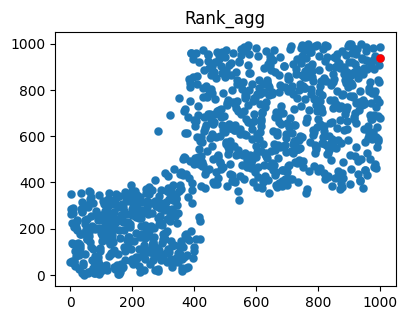

FLOPs: 0.5125668607136328	0.7001366044466338	0.7001366044466338	


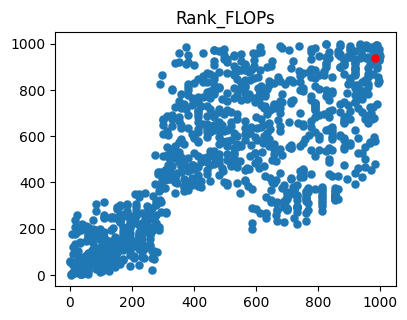

Params: 0.4691375424263369	0.6348514314823601	0.6348514314823602	


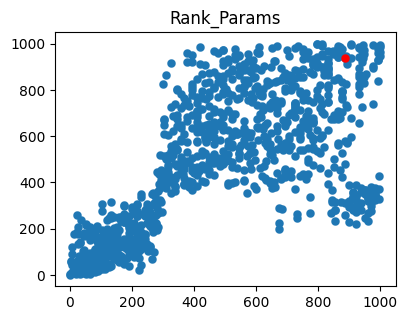

expressivity: 0.5296955008931702	0.7504924330010191	0.7504924330010188	


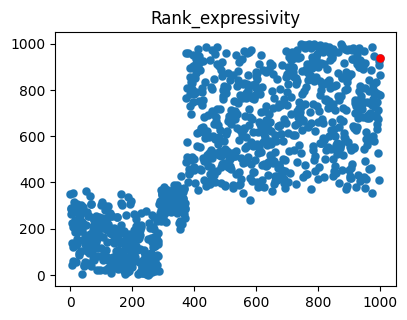

trainability: 0.10786986185709456	0.1720575551048704	0.1720575551048704	


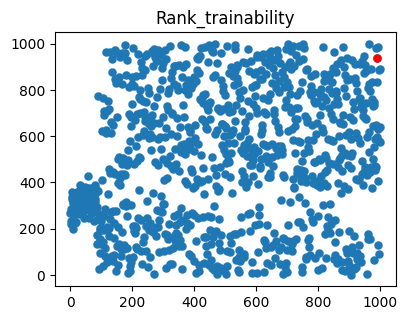

complexity: 0.5125548003642055	0.7001223537640688	0.7001223537640687	


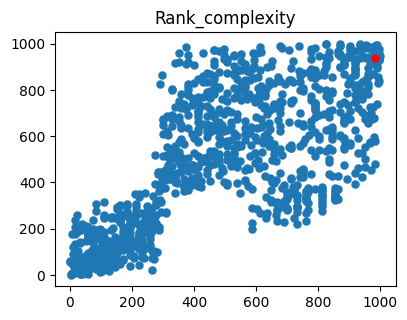

In [10]:
rank_agg = np.log(stats.rankdata(results['complexity']) / l) + np.log(stats.rankdata(results['expressivity']) / l) + np.log(stats.rankdata(results['trainability']) / l)

fig_scale = 1.1

best_idx = np.argmax(rank_agg)

best_arch, acc = proxies['archs'][best_idx], proxies['acc'][best_idx]
print(acc)
print(max(proxies['acc']))

x = stats.rankdata(rank_agg)
y = stats.rankdata(proxies['acc'])
# y = proxies['acc']
kendalltau = stats.kendalltau(x, y)
spearmanr = stats.spearmanr(x, y)
pearsonr = stats.pearsonr(x, y)
print("aggregated: {}\t{}\t{}\t".format(kendalltau[0], pearsonr[0], spearmanr[0]))
plt.figure(figsize=(4*fig_scale,3*fig_scale))
plt.scatter(x, y, linewidths=0.1)
# plt.scatter(x[indices], np.array(y)[indices], linewidths=0.1, c='b')
plt.scatter(x[best_idx], y[best_idx], c="r", linewidths=0.1)
plt.title("Rank_agg")
plt.show()


# for each
metrics = {'FLOPs':proxies['flops'], 'Params':proxies['params']}
for k, v in results.items():
    metrics[k] = v
for k in metrics.keys():
    x = stats.rankdata(metrics[k])
    y = stats.rankdata(proxies['acc'])
#     x = metrics[k]
#     y = proxies['acc']
    kendalltau = stats.kendalltau(x, y)
    spearmanr = stats.spearmanr(x, y)
    pearsonr = stats.pearsonr(x, y)
    print("{}: {}\t{}\t{}\t".format(k, kendalltau[0], pearsonr[0], spearmanr[0]))
    plt.figure(figsize=(4*fig_scale,3*fig_scale))
    plt.scatter(x, y, linewidths=0.1)
    plt.scatter(x[best_idx], y[best_idx], c="r", linewidths=0.1)
    plt.title("Rank_{}".format(k))
    plt.show()